In [111]:
import numpy as np
import sklearn 
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import odeint
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools


#import csvs
train = pd.read_csv("../../data/train.csv")
test = pd.read_csv("../../data/test.csv")
graph = pd.read_csv("../../data/graph.csv")

statesdata = {}
states = pd.Series.unique(train['Province_State'])
num_states = len(states)
for s in states:
    statesdata[s] = train.loc[train['Province_State'] == s ,:]

In [112]:

days = 26

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

def predictARIMA(X, p, d, q, days, sarimax=False):
    start = len(X)
    if sarimax:
        # model = SARIMAX(X, order=(p,d,q), measurement_error=True).fit(disp=False)
        model = SARIMAX(X,order=(p, d, q),
                                trend=(0,0,1,1)).fit(disp=False)
        forecast = model.forecast(days)
    else:
        model = ARIMA(X, order=(p,d,q)).fit()
        forecast = model.predict(start = start, end = start + days)
    return(forecast)

def bestARIMA(X):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))

    for var in pdq:
        try:
            model = ARIMA(X, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
    
    model = ARIMA(X, order=param).fit()
    forecast = model.predict(start = len(X), end = len(X)+26)
    return forecast, param

    
proj = {}
for s in states:
    a = statesdata[s].reset_index()
    confirmed = a['Confirmed']
    deaths = a['Deaths']
    
    X, Y = confirmed.values, deaths.values
    forecastC = predictARIMA(X, 3,2,1, days) # BEST PARAMS SO FAR ARE 3,2,1
    forecastD = predictARIMA(Y, 4,2,3, days) # BEST PARAMS SO FAR ARE 4,2,3

    df = {'Confirmed': forecastC, 'Deaths': forecastD}
    
    proj[s] = pd.DataFrame(df)

In [113]:
order = test.loc[0:49,'Province_State']

# format submission
conf = []
dead = []
fid = 0
for i in range(days):
    for j in order:
        projection = proj[j].iloc[i]
        #print(j, 'day', i)
        conf.append(int(projection['Confirmed']))
        dead.append(int(projection['Deaths']))
        #print(fid)
        fid+=1

test['Confirmed'] = conf
test['Deaths'] = dead

In [114]:
submission = test.drop(columns=['Province_State', 'Date'])
print(submission)
submission.to_csv('team25.csv', index = False, header = True)

ForecastID  Confirmed  Deaths
0              0     127300    2196
1              1       5318      37
2              2     202257    5058
3              3      61760     811
4              4     718207   13150
...          ...        ...     ...
1295        1295     145943    2951
1296        1296      87155    2101
1297        1297      13626     314
1298        1298      92074    1256
1299        1299       4749      43

[1300 rows x 3 columns]


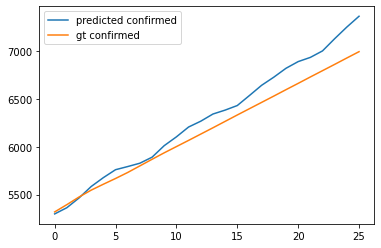

0.023705142378048813


In [115]:
import matplotlib.pyplot as plt

def give_mape(ground_truth_path, prediction_path):
    ground_truth = pd.read_csv(ground_truth_path)
    predictions = pd.read_csv(prediction_path)

    gt_conf = ground_truth['Confirmed']
    gt_dead = ground_truth['Deaths']

    pred_conf = predictions['Confirmed']
    pred_dead = predictions['Deaths']

    pred_conf_state = []
    gt_conf_state = []
    pred_dead_state = []
    gt_dead_state = []

    total = 0
    for i in range(1300):
        if i % 50 == 1:
            pred_conf_state.append(pred_conf[i])
            gt_conf_state.append(gt_conf[i])
            pred_dead_state.append(pred_dead[i])
            gt_dead_state.append(gt_dead[i])
        conf_error = float(pred_conf[i] - gt_conf[i]) / float(gt_conf[i])
        dead_error = float(pred_dead[i] - gt_dead[i]) / float(gt_dead[i])
        total = total + abs(conf_error) + abs(dead_error)

    total = total / 2600

    plt.plot(pred_conf_state, label='predicted confirmed')
    plt.plot(gt_conf_state, label='gt confirmed')
    plt.legend()
    plt.show()
    # plt.plot(pred_dead_state, label='predicted dead')
    # plt.plot(gt_dead_state, label='gt dead')
    # plt.legend()
    # plt.show()

    return total

print(give_mape('team25.csv', '../ValidationTester/ground_truth.csv'))

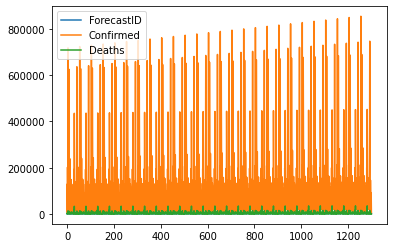

In [116]:
from matplotlib import pyplot
submission.plot()
pyplot.show()